In [10]:
from cv2 import mean
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

*** MS ***
12
Training LSTM model for beer...
Epoch 1/200


C:\Users\raedb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0606
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0142
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0074
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0066
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0069
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0065
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0072
Epoch 8/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0067
Epoch 9/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0058
Epoch 10/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0064
Epoch 11/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0053
Epoch 12/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0057
Epoch 13/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0041
Epoch 14/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0046
Epoch 15/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0028
E

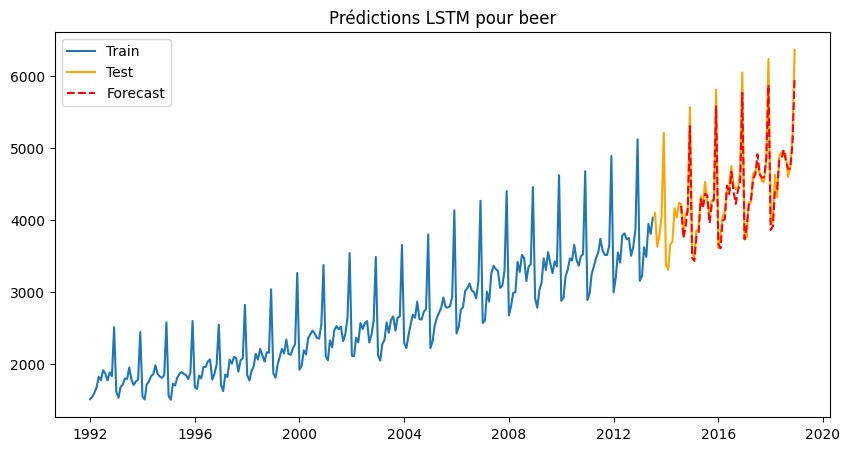

Mean Absolute Percentage Error: 0.03264275231116725
Mean Squared Error: 0.0007311734147651132
R2 Score: 0.9562631419044622
Toutes les prédictions LSTM ont été enregistrées.


In [11]:


# 2. Charger les données
# Charger les données prétraitées
df = pd.read_csv("../datasets/BeerWineLiquor.csv", parse_dates=True, index_col=0)

# S'assurer que l'index est une colonne de type datetime
df.index = pd.to_datetime(df.index)

df.dropna(inplace=True)

# Identifier les colonnes cibles (toutes sauf la date)
target_columns = df.columns.tolist()

# Dictionnaire pour stocker les prédictions
forecast_results = {}

# 3. Normalisation des données
# LSTM fonctionne mieux avec des données normalisées entre 0 et 1 :
scalers = {}
scaled_data = {}

for column in target_columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data[column] = scaler.fit_transform(df[[column]])
    scalers[column] = scaler

# 4. Transformer les données en séquences pour LSTM
def create_sequences(data, seq_length=12):
    """
    Transforme les données en séquences pour le modèle LSTM.
    Chaque séquence contient seq_length valeurs passées pour prédire la suivante.
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

#seq_length: Nombre de pas de temps utilisés pour la prédiction
detected_freq = pd.infer_freq(df.index)
print("***",detected_freq,"***")
if detected_freq in ["D", "B"]:  # Quotidienne ou Business Days
    seq_length = 10
elif detected_freq in ["MS", "M"]:# "justify your choices"
    seq_length = 12
else:
    seq_length = 1
print(seq_length)
# Dictionnaire pour stocker les séquences
sequences = {}

for column in target_columns:
    X, y = create_sequences(scaled_data[column], seq_length)
    sequences[column] = (X, y)

# 5. Séparer les données en Train (80%) et Test (20%)
train_size = int(0.8 * len(df))

train_sequences = {}
test_sequences = {}

for column in target_columns:
    X, y = sequences[column]
    train_sequences[column] = (X[:train_size], y[:train_size])
    test_sequences[column] = (X[train_size:], y[train_size:])

# 6. Définir l'architecture du modèle LSTM
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(200, activation='relu', return_sequences=True, input_shape=input_shape),
        LSTM(200, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# 7. Entraîner un modèle LSTM par colonne
for column in target_columns:
    print(f"Training LSTM model for {column}...")

    X_train, y_train = train_sequences[column]
    X_test, y_test = test_sequences[column]

    # Construire et entraîner le modèle
    model = build_lstm_model((seq_length, 1))
    model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=1)

    train_loss = model.evaluate(X_train, y_train, verbose=0)
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f'Train Loss: {train_loss}')
    print(f'Test Loss: {test_loss}')

    # Faire des prédictions
    y_pred = model.predict(X_test)

    # Inverser la normalisation
    y_pred_rescaled = scalers[column].inverse_transform(y_pred)
    y_test_rescaled = scalers[column].inverse_transform(y_test)

    # Calculer l'erreur
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    print(f"MSE for {column}: {mse:.4f}")

    # Sauvegarder les résultats
    forecast_results[column] = pd.DataFrame({
        "ds": df.index[train_size + seq_length:],
        "yhat": y_pred_rescaled.flatten()
    })

    # Visualisation
    plt.figure(figsize=(10, 5))
    plt.plot(df.index[:train_size], df[column][:train_size], label="Train")
    plt.plot(df.index[train_size:], df[column][train_size:], label="Test", color="orange")
    plt.plot(df.index[train_size + seq_length:], y_pred_rescaled, label="Forecast", linestyle="dashed", color="red")
    plt.title(f"Prédictions LSTM pour {column}")
    plt.legend()
    plt.show()

mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test_seq, predictions)
r2 = r2_score(y_test,y_pred)
mape=mean_absolute_percentage_error(y_test, y_pred)

print(f"Mean Absolute Percentage Error: {mape}")
# print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

# Sauvegarder les prévisions
for col, forecast in forecast_results.items():
    forecast.to_csv(f"forecast_lstm_{col}.csv", index=False)

print("Toutes les prédictions LSTM ont été enregistrées.")